In [3]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [4]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).mean(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def import_throughput(res_dir):
    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
#     throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
#     throughput_csv['rxpck/s'] *= 1e-6
#     throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    net_wg = average_data(throughput_wg)
    net_phy = average_data(throughput_phy)
    
    return net_wg, net_phy

def import_cpu(res_dir):
    cpu_csv = pd.read_csv(f"{res_dir}/summary/server/cpu-sar.csv")
    
#     cpu_csv['client'] *= 10
    cpu_csv['used'] = 100 - cpu_csv['idle']

    cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    
    per_core = cpu[cpu.core != -1]
    global_cpu = cpu[cpu.core == -1]
    
    return global_cpu, per_core

def import_iperf(res_dir):
    df_t = []
    for i in range(1, 2):
        try:
            net_client_csv = pd.read_csv(
                f"{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).median().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir):
    df_t = []
    for i in range(1, 11):
        try:
            latency_csv = pd.read_csv(
                f"{res_dir}/summary/clients/latency-{i}.csv",
                names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                skiprows=1
            )
        except:
            continue
        latency_df = average_data(latency_csv, keep=['cpu', 'client'])
#         latency_df['client'] *= 10
        latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
        latency_df['node'] = i
        df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    latency_df = df.groupby(['cpu', 'client']).median().reset_index()
    
    return latency_df

In [5]:
def infos_resdir(resdir):
    t = f"{maindir}/{resdir}"
    curr_dir_f = f"{t}/EXPERIMENT_DATA/CURRENT_EXP"
    with open(curr_dir_f) as f:
        curr_dir = f.readlines()[0].strip()
    return {
        'test': curr_dir,
        'path': t
    }


In [6]:
maindir = "../cryptonce-trace-v2"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]

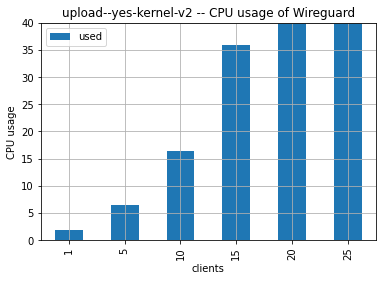

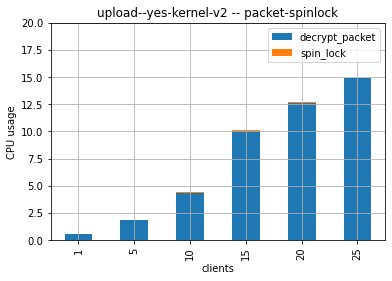

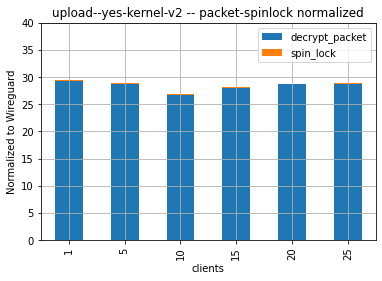

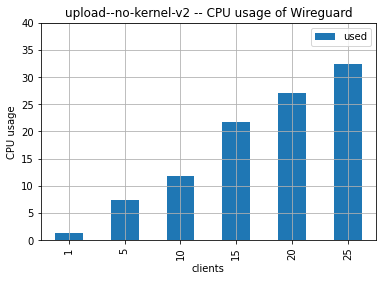

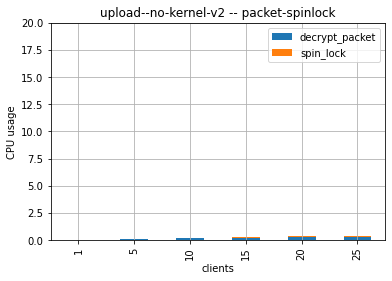

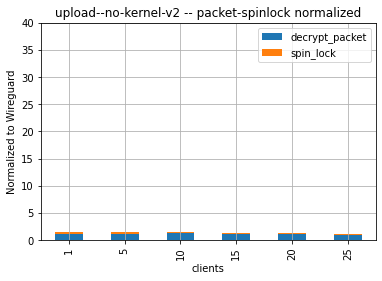

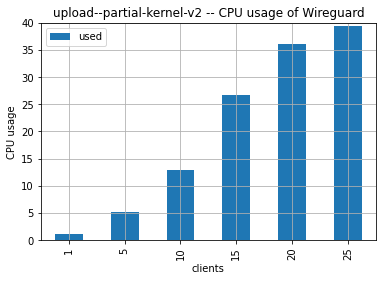

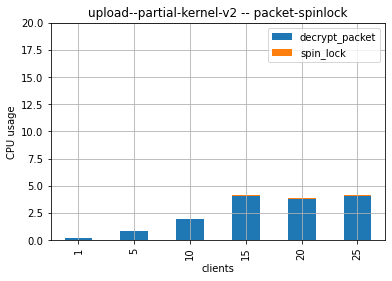

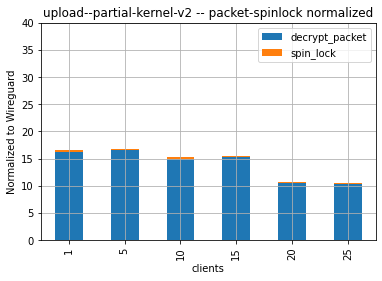

In [7]:
for res_dir in res_dirs:
    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()

    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()
    df = df.reset_index(drop=True)

    cpu, pcpu = import_cpu(res_dir['path'])
    cpu = cpu.reset_index(drop=True)

    df_2 = pd.concat([cpu, df], axis=1)
    df_2.decrypt_packet = df_2.decrypt_packet * df_2.used / 100
    df_2.spin_lock = df_2.spin_lock * df_2.used / 100
    
    df_2.plot.bar(x='clients', y='used', grid=True, ylabel="CPU usage",
                 ylim=[0, 40], 
                 title=f"{res_dir['test']} -- CPU usage of Wireguard")
    plt.show()
    df_2.plot.bar(x='clients', y=['decrypt_packet', 'spin_lock'], 
                grid=True, ylabel="CPU usage", 
                ylim=[0, 20], stacked=True,
                 title=f"{res_dir['test']} -- packet-spinlock")
    plt.show()
    df.plot.bar(x='clients', y=['decrypt_packet', 'spin_lock'], 
                grid=True, ylabel="Normalized to Wireguard", 
                ylim=[0, 40], stacked=True,
                title=f"{res_dir['test']} -- packet-spinlock normalized")
    plt.show()
#     df.plot.bar(x='clients', y=['decrypt_worker'], 
#                 grid=True, ylabel="CPU usage", 
#                 ylim=[0, 40], 
#                 title=f"{res_dir['test']} -- worker")
#     plt.show()

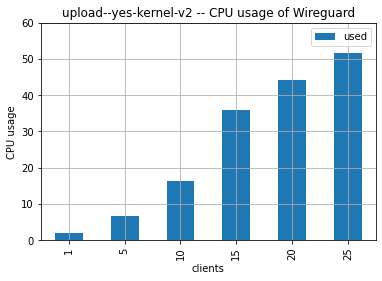

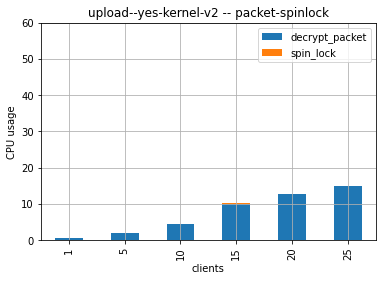

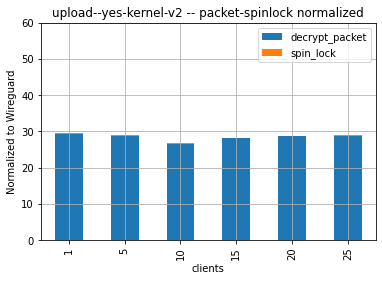

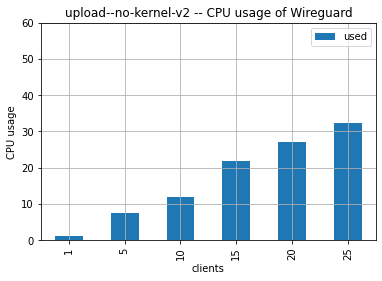

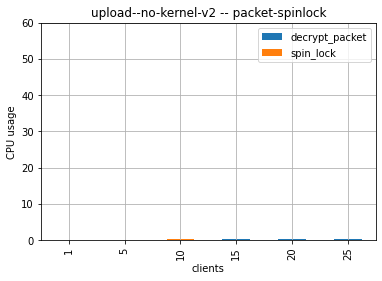

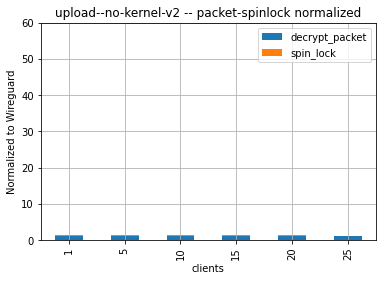

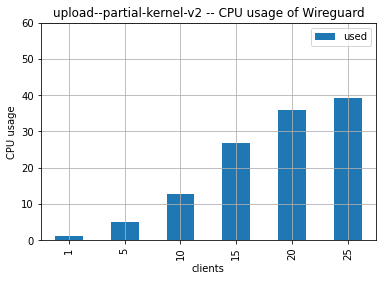

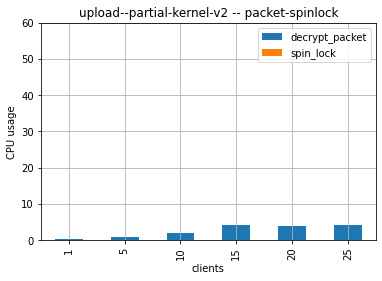

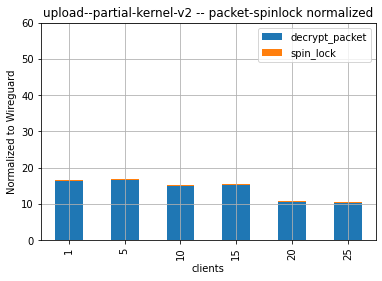

In [8]:
maindir = "../cryptonce-trace-v2"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
for res_dir in res_dirs:
    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()

    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()
    df = df.reset_index(drop=True)

    cpu, pcpu = import_cpu(res_dir['path'])
    cpu = cpu.reset_index(drop=True)

    df_2 = pd.concat([cpu, df], axis=1)
    df_2.decrypt_packet = df_2.decrypt_packet * df_2.used / 100
    df_2.spin_lock = df_2.spin_lock * df_2.used / 100
    
    df_2.plot.bar(x='clients', y='used', grid=True, ylabel="CPU usage",
                 ylim=[0, 60], 
                 title=f"{res_dir['test']} -- CPU usage of Wireguard")
    plt.show()
    df_2.plot.bar(x='clients', y=['decrypt_packet', 'spin_lock'], 
                grid=True, ylabel="CPU usage", 
                ylim=[0, 60], stacked=True,
                 title=f"{res_dir['test']} -- packet-spinlock")
    plt.show()
    df.plot.bar(x='clients', y=['decrypt_packet', 'spin_lock'], 
                grid=True, ylabel="Normalized to Wireguard", 
                ylim=[0, 60], stacked=True,
                title=f"{res_dir['test']} -- packet-spinlock normalized")
    plt.show()
#     df.plot.bar(x='clients', y=['decrypt_worker'], 
#                 grid=True, ylabel="CPU usage", 
#                 ylim=[0, 40], 
#                 title=f"{res_dir['test']} -- worker")
#     plt.show()